## Important Libbraries

In [1]:
!pip install -U datasets huggingface_hub transformers[torch] evaluate peft bitsandbytes --quiet

In [3]:
from transformers import TrainingArguments, Trainer
import torch

2024-05-27 04:37:07.259991: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-27 04:37:07.260137: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-27 04:37:07.393335: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Pre-Processing and Loading

In [5]:
from datasets import load_dataset

dataset = load_dataset("nyu-mll/multi_nli")

Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating validation_matched split:   0%|          | 0/9815 [00:00<?, ? examples/s]

Generating validation_mismatched split:   0%|          | 0/9832 [00:00<?, ? examples/s]

In [6]:
from transformers import BitsAndBytesConfig

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=False,
)

In [7]:
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("meta-llama/Meta-Llama-3-8B", padding_side='left')
tokenizer.pad_token = tokenizer.eos_token
tokenizer.add_eos_token = True

model = AutoModelForCausalLM.from_pretrained(
    "meta-llama/Meta-Llama-3-8B",
    quantization_config=bnb_config,
    device_map="auto",
)

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/177 [00:00<?, ?B/s]

# Interesting:
- Model perfers `should` over `must` and performers better.
- Model seems to have a bias to classifying the extremes
- Model seems to perform better when providing a longer description

In [8]:
def generate_instructions(example):
    example['prompt'] = f'''Textual Entailment Task:
- If the *premise* logically implies the negation or opposite of the *hypothesis* (i.e., they are contradicting), then the *Sentence Label* should be equal to 2.
- If the *premise* does not provide enough information to determine if the *hypothesis* is true or false (i.e., they are neutral), then the *Sentence Label* should be equal to 1.
- If the *premise* logically implies or entails the *hypothesis*, then the *Sentence Label* should be equal to 0.
- The sentence label should end with 0, 1, or 2. (e.g. Sentence label = 1)
------------------
Premise: "{example['premise']}"
Hypothesis: "{example['hypothesis']}"
Sentence label = '''

    return example

dataset = dataset.map(generate_instructions)

Map:   0%|          | 0/392702 [00:00<?, ? examples/s]

Map:   0%|          | 0/9815 [00:00<?, ? examples/s]

Map:   0%|          | 0/9832 [00:00<?, ? examples/s]

In [9]:
def predict(examples):
  tokenized = tokenizer(examples, return_tensors='pt', truncation=True, padding=True, max_length=256).to(device)
  output = model.generate(**tokenized, pad_token_id=tokenizer.pad_token_id, max_new_tokens=1, do_sample=False, tokenizer=tokenizer)
  texts = tokenizer.batch_decode(output)

  #print('\n'.join(texts))

  # TODO: Handel cases where model doesn't like to follow the instructions
  predictions = [int(text[-1]) if text[-1] in ['0', '1', '2'] else -1 for text in texts]

  return predictions

In [10]:
from tqdm import tqdm

In [11]:
with torch.no_grad():
  torch.cuda.empty_cache()

In [12]:
model.generation_config.temperature=None
model.generation_config.top_p=None

In [13]:
predictions = []
references = []
model.eval()

dataset_len = round(len(dataset['validation_matched']) * 1.0)

with torch.no_grad():
  for i in tqdm(range(0, dataset_len, 8)):
    examples = dataset['validation_matched'][i + 0:i + 8]
    prediction = predict(examples['prompt'])

    reference = examples['label']

    predictions += prediction
    references += reference

100%|██████████| 1227/1227 [1:17:14<00:00,  3.78s/it]


In [14]:
import evaluate

accuracy = evaluate.load("accuracy")

In [15]:
erroneous_indices = [i for i, p in enumerate(predictions) if p == -1]
print(len(erroneous_indices))
predictions_fixed = [p for i, p in enumerate(predictions) if not i in erroneous_indices]
references_fixed = [r for i, r in enumerate(references) if not i in erroneous_indices]

131


In [16]:
accuracy.compute(predictions=predictions_fixed, references=references_fixed)

{'accuracy': 0.6334159438248658}

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

In [18]:
matrix = confusion_matrix(y_true=references_fixed, y_pred=predictions_fixed, labels=[0, 1, 2])

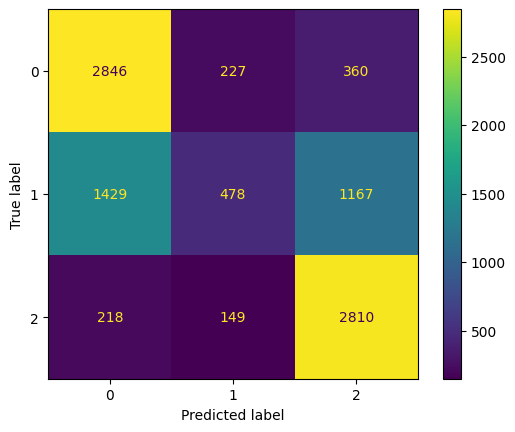

In [19]:
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot()
plt.show()

In [20]:
predictions = []
references = []
model.eval()

dataset_len = round(len(dataset['validation_mismatched']) * 1.0)

with torch.no_grad():
    for i in tqdm(range(0, dataset_len, 8)):
        examples = dataset['validation_mismatched'][i + 0:i + 8]
        prediction = predict(examples['prompt'])

        reference = examples['label']

        predictions += prediction
        references += reference

100%|██████████| 1229/1229 [1:17:24<00:00,  3.78s/it]


In [21]:
erroneous_indices = [i for i, p in enumerate(predictions) if p == -1]
print(len(erroneous_indices))
predictions_fixed = [p for i, p in enumerate(predictions) if not i in erroneous_indices]
references_fixed = [r for i, r in enumerate(references) if not i in erroneous_indices]

175


In [22]:
accuracy.compute(predictions=predictions_fixed, references=references_fixed)

{'accuracy': 0.6422284353318836}

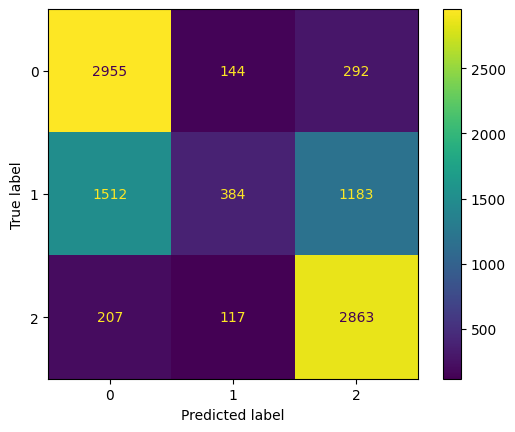

In [23]:
matrix = confusion_matrix(y_true=references_fixed, y_pred=predictions_fixed, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot()
plt.show()